# Exploratory Data Analysis (EDA) — Fantasy Premier League 2024/2025

## 1. Introduction

This notebook presents an Exploratory Data Analysis (EDA) performed on a dataset from the public Fantasy Premier League (FPL) repository, available at: https://github.com/vaastav/Fantasy-Premier-League

The central objective of this analysis is to prepare a clean, structured dataset suitable for the application of association rule mining algorithms, utilizing player performance data throughout the gameweeks of the 2024/2025 season. The entire investigation is conducted with a focus on identifying patterns between match events, performance metrics, and player statistical results.

### 1.1. What is Fantasy Premier League?

*Fantasy Premier League (FPL)* is a global game where millions of users build virtual teams consisting of real players from the **English Premier League**. In each gameweek, players accumulate points based on their actual performance: goals, assists, clean sheets, minutes played, bonuses, among other criteria.

The repository used in this analysis contains complete extractions from the FPL API, gathering thousands of records regarding detailed statistics for each player in every gameweek, ranging from traditional metrics (goals, assists) to derived metrics (influence, threat, creativity).


### 1.2. Selection of the ``merged_gw.csv`` dataset

Apesar de o repositório conter dezenas de ficheiros com diferentes tipos de dados (preços, estatísticas históricas, equipas, metadata de jogadores, etc.), apenas um ficheiro foi selecionado:

**`data/2024-25/gws/merged_gw.csv`**

This dataset aggregates, in a single structure, **all events recorded in each gameweek**, for each player, including:

- points,
- minutes played,
- offensive and defensive actions,
- expected contributions (xG, xA),
- advanced metrics,
- price and variations,
- possession and selection data,
- actions relevant to individual performance.

This dataset is ideal for association rules since each row represents a player performance "transaction" in a gameweek, allowing for the identification of patterns between different characteristics.


### 1.3. Objective of the notebook

The objective of this notebook is to:

1. Describe and understand the selected dataset.
2. Perform a deep EDA, covering:
   - data structure,
   - statistical analysis,
   - identification of issues,
   - identification of issues,
   - study of distributions and correlations.
3. Transform continuous variables into binary attributes suitable for the Apriori algorithm.
4. Build a final dataset prepared for association rule extraction.

By the end of the EDA, the dataset will be clean, consistent, and properly transformed, forming the basis for the pattern mining phase.

---

## 2. Loading the Dataset

To begin the EDA, we proceed with loading the main libraries necessary for data manipulation and visualization, followed by reading the ``merged_gw.csv`` file, located in the repository's folder structure.

This file is locally located in the folder ``data\raw\merger_gw.csv``.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# use a more tolerant CSV parser to skip malformed lines that cause the ParserError
df = pd.read_csv("../data/raw/merged_gw.csv", engine='python', sep=',', on_bad_lines='skip')

df.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,modified,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Alex Scott,MID,Bournemouth,1.6,0,0,11,0,12.8,77,0.01,0.01,0.0,1.02,6,1,0,3.6,22.8,2024-08-17T14:00:00Z,62,False,16,0,0,0,0,1,0,4339,1,1,1,0.0,2,0,0,0,50,False,0,1
1,Carlos Miguel dos Santos Pereira,GK,Nott'm Forest,2.2,0,0,0,0,0.0,427,0.00,0.00,0.0,0.00,6,0,0,0.0,0.0,2024-08-17T14:00:00Z,0,False,3,0,0,0,0,1,0,33324,0,1,1,0.0,0,0,0,0,45,True,0,1
2,Tomiyasu Takehiro,DEF,Arsenal,0.0,0,0,0,0,0.0,22,0.00,0.00,0.0,0.00,2,0,0,0.0,0.0,2024-08-17T14:00:00Z,0,False,20,0,0,0,0,1,0,8462,0,0,2,0.0,0,0,0,0,50,True,0,1
3,Malcolm Ebiowei,MID,Crystal Palace,0.0,0,0,0,0,0.0,197,0.00,0.00,0.0,0.00,8,0,0,0.0,0.0,2024-08-18T13:00:00Z,0,False,4,0,0,0,0,1,0,716,0,1,2,0.0,0,0,0,0,45,False,0,1
4,Ben Brereton Díaz,MID,Southampton,1.0,0,0,-2,0,14.0,584,0.02,0.32,0.3,0.25,5,1,0,3.3,2.6,2024-08-17T14:00:00Z,70,False,15,0,0,0,0,1,0,66244,1,0,1,16.0,1,0,0,0,55,False,1,1


---

## 3. Dataset Structure

Before starting the detailed exploratory analysis, it is important to understand the dataset's structure, specifically the type of each column, the presence of null values, and the total volume of entries. This initial view allows us to identify early on:

- Which variables are numeric or categorical

- The dimension of the dataset and the impact this will have on processing

- Potential columns that require type conversion or specific preprocessing

To do this, we use the ``df.info()`` command, which summarizes the internal structure of the DataFrame and serves as a starting point for the subsequent EDA steps.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14178 entries, 0 to 14177
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        14178 non-null  object 
 1   position                    14178 non-null  object 
 2   team                        14178 non-null  object 
 3   xP                          14178 non-null  float64
 4   assists                     14178 non-null  int64  
 5   bonus                       14178 non-null  int64  
 6   bps                         14178 non-null  int64  
 7   clean_sheets                14178 non-null  int64  
 8   creativity                  14178 non-null  float64
 9   element                     14178 non-null  int64  
 10  expected_assists            14178 non-null  float64
 11  expected_goal_involvements  14178 non-null  float64
 12  expected_goals              14178 non-null  float64
 13  expected_goals_conceded     141

After understanding the dataset structure, it is essential to analyze the descriptive statistics of the numerical variables. This step allows us to identify:

- Central tendencies (mean, median)

- Dispersion and range of data (std, min, max)

- Potential outliers

- Scale differences between variables

- Distribution issues that may justify normalization, discretization, or binarization

The ``df.describe()`` command provides a complete statistical summary of numerical columns, serving as a basis for informed decisions regarding attribute preprocessing and transformation.

In [3]:
df.describe(include='all')

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,modified,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
count,14178,14178,14178,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,14178.00000,14178.000000,14178.000000,14178.000000,14178.000000,14178,14178.000000,14178,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,1.417800e+04,14178.000000,14178.000000,14178.000000,14178.000000,14178.000000,1.417800e+04,1.417800e+04,1.417800e+04,14178.000000,14178,14178.000000,14178.000000
unique,724,4,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,Raúl Jiménez,MID,Brighton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-21T14:00:00Z,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
freq,21,6436,947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,398,NaN,14178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7110,NaN,NaN
mean,NaN,NaN,NaN,1.174129,0.038369,0.093031,5.023769,0.076456,4.679539,340.039780,0.028891,0.073158,0.044272,0.481510,107.65115,0.483354,0.042742,1.566695,6.752560,NaN,29.035478,NaN,10.495204,0.001199,0.000564,0.000564,0.001975,11.215475,0.094442,2.330977e+05,0.324305,1.480251,1.521865,4.249189,1.203061,4.119439e+01,1.829234e+04,1.825072e+04,49.558400,NaN,0.065454,11.215475
std,NaN,NaN,NaN,1.794372,0.208977,0.456648,9.576491,0.265736,10.607323,196.844226,0.087781,0.193644,0.151994,0.783524,60.55080,0.934950,0.223804,2.828839,12.586388,NaN,38.554664,NaN,5.768158,0.036589,0.023748,0.023748,0.044397,6.046624,0.642730,6.312137e+05,0.468131,1.266242,1.186369,10.993013,2.361287,8.109667e+04,6.851884e+04,6.286187e+04,10.509246,NaN,0.247333,6.046624
min,NaN,NaN,NaN,-2.200000,0.000000,0.000000,-25.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-5.000000,-2.741008e+06,0.000000e+00,0.000000e+00,39.000000,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,169.000000,0.000000,0.000000,0.000000,0.000000,55.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,5.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,5.575250e+03,0.000000,1.000000,1.000000,0.000000,0.000000,-1.894000e+03,5.700000e+01,2.410000e+02,44.000000,NaN,0.000000,6.000000
50%,NaN,NaN,NaN,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,340.000000,0.000000,0.000000,0.000000,0.000000,108.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,10.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,2.414700e+04,0.000000,1.000000,1.000000,0.000000,0.000000,-1.650000e+02,5.730000e+02,1.560000e+03,47.000000,NaN,0.000000,11.000000
75%,NaN,NaN,NaN,2.000000,0.000000,0.000000,6.000000,0.000000,2.500000,509.000000,0.010000,0.030000,0.000000,0.820000,161.00000,1.000000,0.000000,2.200000,9.200000,NaN,76.000000,NaN,15.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,1.563465e+05,1.000000,2.000000,2.000000,2.000000,1.000000,2.800000e+01,5.843250e+03,1.008375e+04,52.000000,NaN,0.000000,17.000000


### **3.1 Removal of Irrelevant Attributes**

In this section, we proceed with the elimination of attributes considered irrelevant or detrimental to the association rule modeling process. Since the goal consists of identifying patterns in player performance per gameweek, it is essential to keep only variables that represent events, performances, and characteristics directly related to the game.

The elimination of attributes was guided by three main criteria:

#### **a) Attributes that do not contribute to performance patterns**
Variables like ``name``, ``element``, ``team_h_score``, and ``team_a_score`` do not represent behaviors relatable to each other (e.g., it is not useful to discover that "when element 123 plays, element 456 scores a goal"). Likewise, the player identifier (``element``) and the name do not carry any analytical value for association rules.

#### **b) Highly derived, redundant, or duplicate variables**
Attributes like ``expected_goals``, ``expected_assists``, and ``expected_goal_involvements`` are strongly correlated with each other, potentially introducing redundancy. In this context, only ``expected_goal_involvements`` is kept, as it is the most comprehensive metric of the three.

#### **c) Attributes irrelevant to the performance context**
Administrative or logistical variables, such as:
- `kickoff_time`
- `modified`
- `fixture`
- `opponent_team`

have no direct impact on performance or are not expressive for association rules.

Additionally, variables related to transfers and selection (``selected``, ``transfers_in``, ``transfers_out``, ``transfers_balance``) represent user behavior rather than player behavior, which falls outside the defined objective: **to discover patterns in performance, not in manager choices**.

#### **Retained Attributes**
Attributes expressing real match events or metrics consolidatable into a categorical format were retained, such as:
- `goals_scored`, `assists`, `clean_sheets`, `bonus`
- `minutes`, `starts`
- `yellow_cards`, `red_cards`, `penalties_missed`, `penalties_saved`
- Composite metrics like: `ict_index`, `influence`, `creativity`, `threat`
- Final KPI: `total_points`
- Reduced contextual information: `position`, `team`, `was_home`

Retaining these attributes allows them to be discretised or transformed into binary variables representing events (e.g., "scored a goal", "had more than X points") in a later phase, adapting the dataset to the Apriori algorithm.

After this analysis, we proceed with the programmatic elimination of redundant or irrelevant columns.

In [4]:
# List of columns to drop based on previous analysis
cols_to_drop = [
    # Identifiers or attributes without analytical value
    "name", "element", "kickoff_time", "modified",

    # Highly correlated — keep only expected_goal_involvements
    "expected_goals", "expected_assists",

    # Attributes irrelevant to performance
    "fixture", "opponent_team",

    # User behavior (not actual performance)
    "transfers_balance", "transfers_in", "transfers_out", "selected",

    # Global scores that do not represent individual action
    "team_h_score", "team_a_score",

    # Temporal attribute that does not contribute to association rule analysis
    "round", "GW"
]

# Removal of columns
df_cleaned = df.drop(columns=cols_to_drop)

# Show result
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14178 entries, 0 to 14177
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   position                    14178 non-null  object 
 1   team                        14178 non-null  object 
 2   xP                          14178 non-null  float64
 3   assists                     14178 non-null  int64  
 4   bonus                       14178 non-null  int64  
 5   bps                         14178 non-null  int64  
 6   clean_sheets                14178 non-null  int64  
 7   creativity                  14178 non-null  float64
 8   expected_goal_involvements  14178 non-null  float64
 9   expected_goals_conceded     14178 non-null  float64
 10  goals_conceded              14178 non-null  int64  
 11  goals_scored                14178 non-null  int64  
 12  ict_index                   14178 non-null  float64
 13  influence                   141

---

## 4. Null Value Analysis

The presence of null values is common in datasets coming from the FPL API, mainly because certain metrics do not apply to all positions (for example, goalkeepers do not score goals; forwards do not make saves).

In this phase:

- we identify the quantity of missing values per attribute;
- we evaluate the relevance of each attribute;
- we decide if null values should be kept, imputed, or converted to an indicative value.

Most attributes will be kept as is, due to their positional nature.

In [5]:
df_cleaned.isna().sum().sort_values(ascending=False)

position                      0
team                          0
xP                            0
assists                       0
bonus                         0
bps                           0
clean_sheets                  0
creativity                    0
expected_goal_involvements    0
expected_goals_conceded       0
goals_conceded                0
goals_scored                  0
ict_index                     0
influence                     0
minutes                       0
own_goals                     0
penalties_missed              0
penalties_saved               0
red_cards                     0
saves                         0
starts                        0
threat                        0
total_points                  0
value                         0
was_home                      0
yellow_cards                  0
dtype: int64

---

## 5. One-Hot Encoding of Categorical Variables (``position`` and ``team``)

The dataset contains two categorical variables essential for player performance analysis:

- **`position`** (GKP, DEF, MID, FWD)  
- **`team`** (player's team in each gameweek)

For these variables to be used in an association rule model, it is necessary to convert them to a binary format. The Apriori algorithm cannot interpret text or categories, requiring that each possible category be represented by an independent variable.

In this context, **one-hot encoding** is applied, which transforms each category into a distinct column containing binary values (0 or 1). For example:

- The ``position`` variable becomes represented by columns like ``pos_DEF``, ``pos_MID``, ``pos_FWD``, and ``pos_GKP``.

- The ``team`` variable unfolds into multiple columns, one for each Premier League team, such as ``team_Arsenal``, ``team_Liverpool``, ``team_Man_City``, among others.

This transformation allows:

1. **Representing categories explicitly and independently**, facilitating the creation of rules like "DEFENDER + CLEAN SHEET → HIGH SCORE".

2. **Preparing data for the binarization process**, a crucial step for building the transactional matrix used by Apriori.

3. **Maintaining granularity without information loss**, allowing specific patterns by position or team to be discovered.

After applying one-hot encoding, the dataset becomes fully compatible with the discretization process and subsequent association rule mining.

In [6]:
import pandas as pd 

df_onehot = df_cleaned.copy()

df_onehot = pd.get_dummies(df_onehot, columns=['position', 'team'],prefix=["pos", "team"], dtype=int)

df_onehot.head()

,xP,assists,bonus,bps,clean_sheets,creativity,expected_goal_involvements,expected_goals_conceded,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,starts,threat,total_points,value,was_home,yellow_cards,pos_DEF,pos_FWD,pos_GK,pos_MID,team_Arsenal,team_Aston Villa,team_Bournemouth,team_Brentford,team_Brighton,team_Chelsea,team_Crystal Palace,team_Everton,team_Fulham,team_Ipswich,team_Leicester,team_Liverpool,team_Man City,team_Man Utd,team_Newcastle,team_Nott'm Forest,team_Southampton,team_Spurs,team_West Ham,team_Wolves
0,1.6,0,0,11,0,12.8,0.01,1.02,1,0,3.6,22.8,62,0,0,0,0,0,1,0.0,2,50,False,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2.2,0,0,0,0,0.0,0.00,0.00,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,45,True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.0,0,0,0,0,0.0,0.00,0.00,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,50,True,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0.0,0.00,0.00,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,45,False,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,-2,0,14.0,0.32,0.25,1,0,3.3,2.6,70,0,0,0,0,0,1,16.0,1,55,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


---

## 6. Binarization and Discretization of Numerical Variables

The Apriori algorithm requires that all variables be in a binary format, representing the presence or absence of an attribute. Since the dataset contains numerous numerical variables with different scales, it is necessary to convert them into discrete attributes before generating the transactional matrix.

To do this, two main strategies are adopted:

#### **1. Logical Binarization for Count Attributes**

Columns where a value greater than zero directly represents a relevant event (such as goals, assists, or cards) are transformed into binary variables:

- `goals_scored` → `1` if the player scored, otherwise `0`
- `assists` → `1` if they assisted
- `yellow_cards`, `red_cards`, etc.

The analysis of data distribution, illustrated in the graphs below, corroborates this approach. A high dispersion (sparsity) is observed, with a predominant concentration of '0' values and a reduced frequency of positive values. In certain cases, the variable appears naturally dichotomous (only '0' or '1').


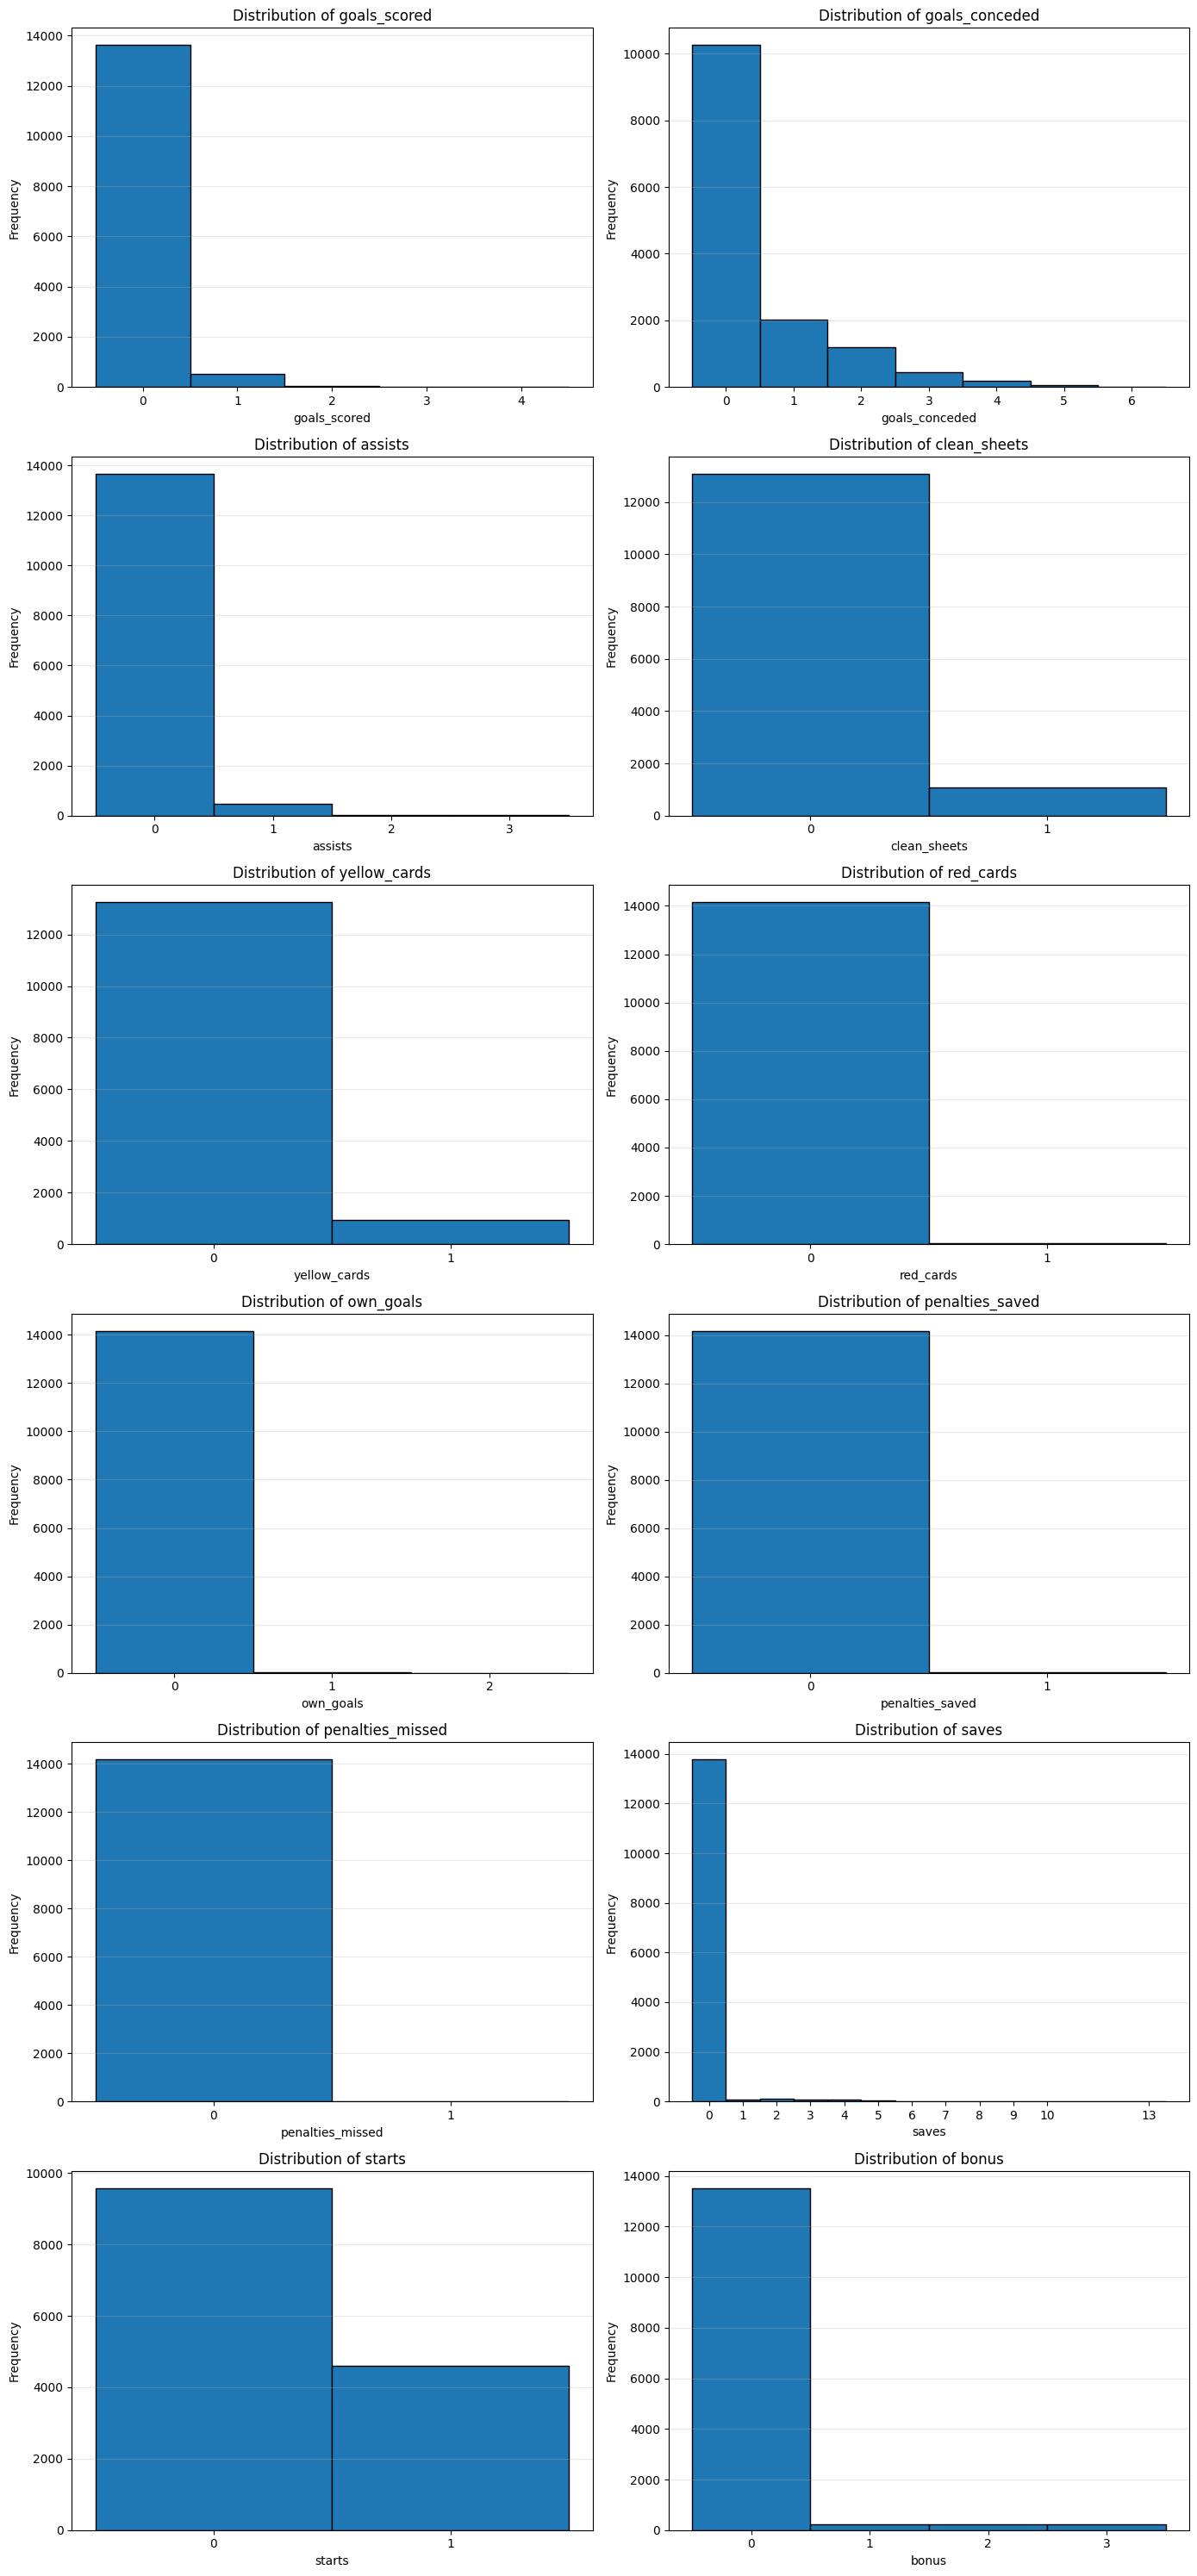

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math

# List of discrete numerical variables (counts)
cols_to_plot = [
    "goals_scored", "goals_conceded", "assists", "clean_sheets", "yellow_cards",
    "red_cards", "own_goals", "penalties_saved", "penalties_missed",
    "saves", "starts", "bonus"
]

# Create subplots with dynamically calculated number of rows
n_cols = 2
n_rows = math.ceil(len(cols_to_plot) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 5 * n_rows))
axes = axes.ravel()

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    
    # Create histogram
    ax.hist(df[col], bins=np.arange(df[col].min(), df[col].max() + 2) - 0.5, edgecolor='black')
    
    # Define integer ticks
    unique_vals = sorted(df[col].unique())
    ax.set_xticks(unique_vals)
    
    # Titles
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Based on the observed distribution, the following transformation rules will be applied to finalize data preparation:

1. **Conversion to Presence/Absence**: Attributes like ``goals_scored``, ``goals_conceded``, ``assists``, ``bonus``, and ``own_goals`` will be binarized. Regardless of the quantity (e.g., 1 or 3 goals), the value will be 1 if the event occurred and 0 otherwise.

2. **Native Binary Variables**: The attributes ``clean_sheets``, ``yellow_cards``, ``red_cards``, ``penalties_saved``, ``penalties_missed``, and ``starts`` will remain unchanged, as their values are already strictly between 0 and 1.

3. **Categorization of the ``saves`` Variable**: Due to the range of values (0 to 13), this metric will be segmented into four new attributes that qualify the goalkeeper's performance:

- save_null (0);

- save_low (1–2);

- save_medium (3–5);

- save_high (7–13).

This approach allows generating rules such as:

> *“Player scored and was playing at home → high probability of getting bonus.”*


In [8]:
import pandas as pd

df_bin = df_onehot.copy()

# Binary discretization for count columns
binary_cols = [
    "goals_scored","goals_conceded", "assists", "own_goals", "bonus"
]

for col in binary_cols:
    df_bin[col] = (df_bin[col] >= 1).astype(int)

# Specific discretization for "saves"
df_bin["save_null"] = (df_bin["saves"] == 0).astype(int)
df_bin["save_low"] = (df_bin["saves"] <= 2).astype(int)
df_bin["save_medium"] = ((df_bin["saves"] > 2) & (df_bin["saves"] <= 5)).astype(int)
df_bin["save_high"] = (df_bin["saves"] > 5).astype(int)

# (optional: remove the original column)
df_bin.drop(columns=["saves"], inplace=True)

#### **2. Range Discretization for Continuous Variables**

Direct binarization is not suitable for continuous performance metrics, such as ``ict_index``, ``creativity``, or ``total_points``.

To preserve the granularity of this data in a format compatible with the Apriori algorithm, discretization into ranges (bins) was applied.

The selected methodology consists of dividing the variables into tertiles, classifying values into three qualitative levels: low, medium, and high.

Thus, before executing the data transformation, distribution histograms (figure below) were analyzed to understand value dispersion and confirm the viability of segmentation into three distinct intervals.

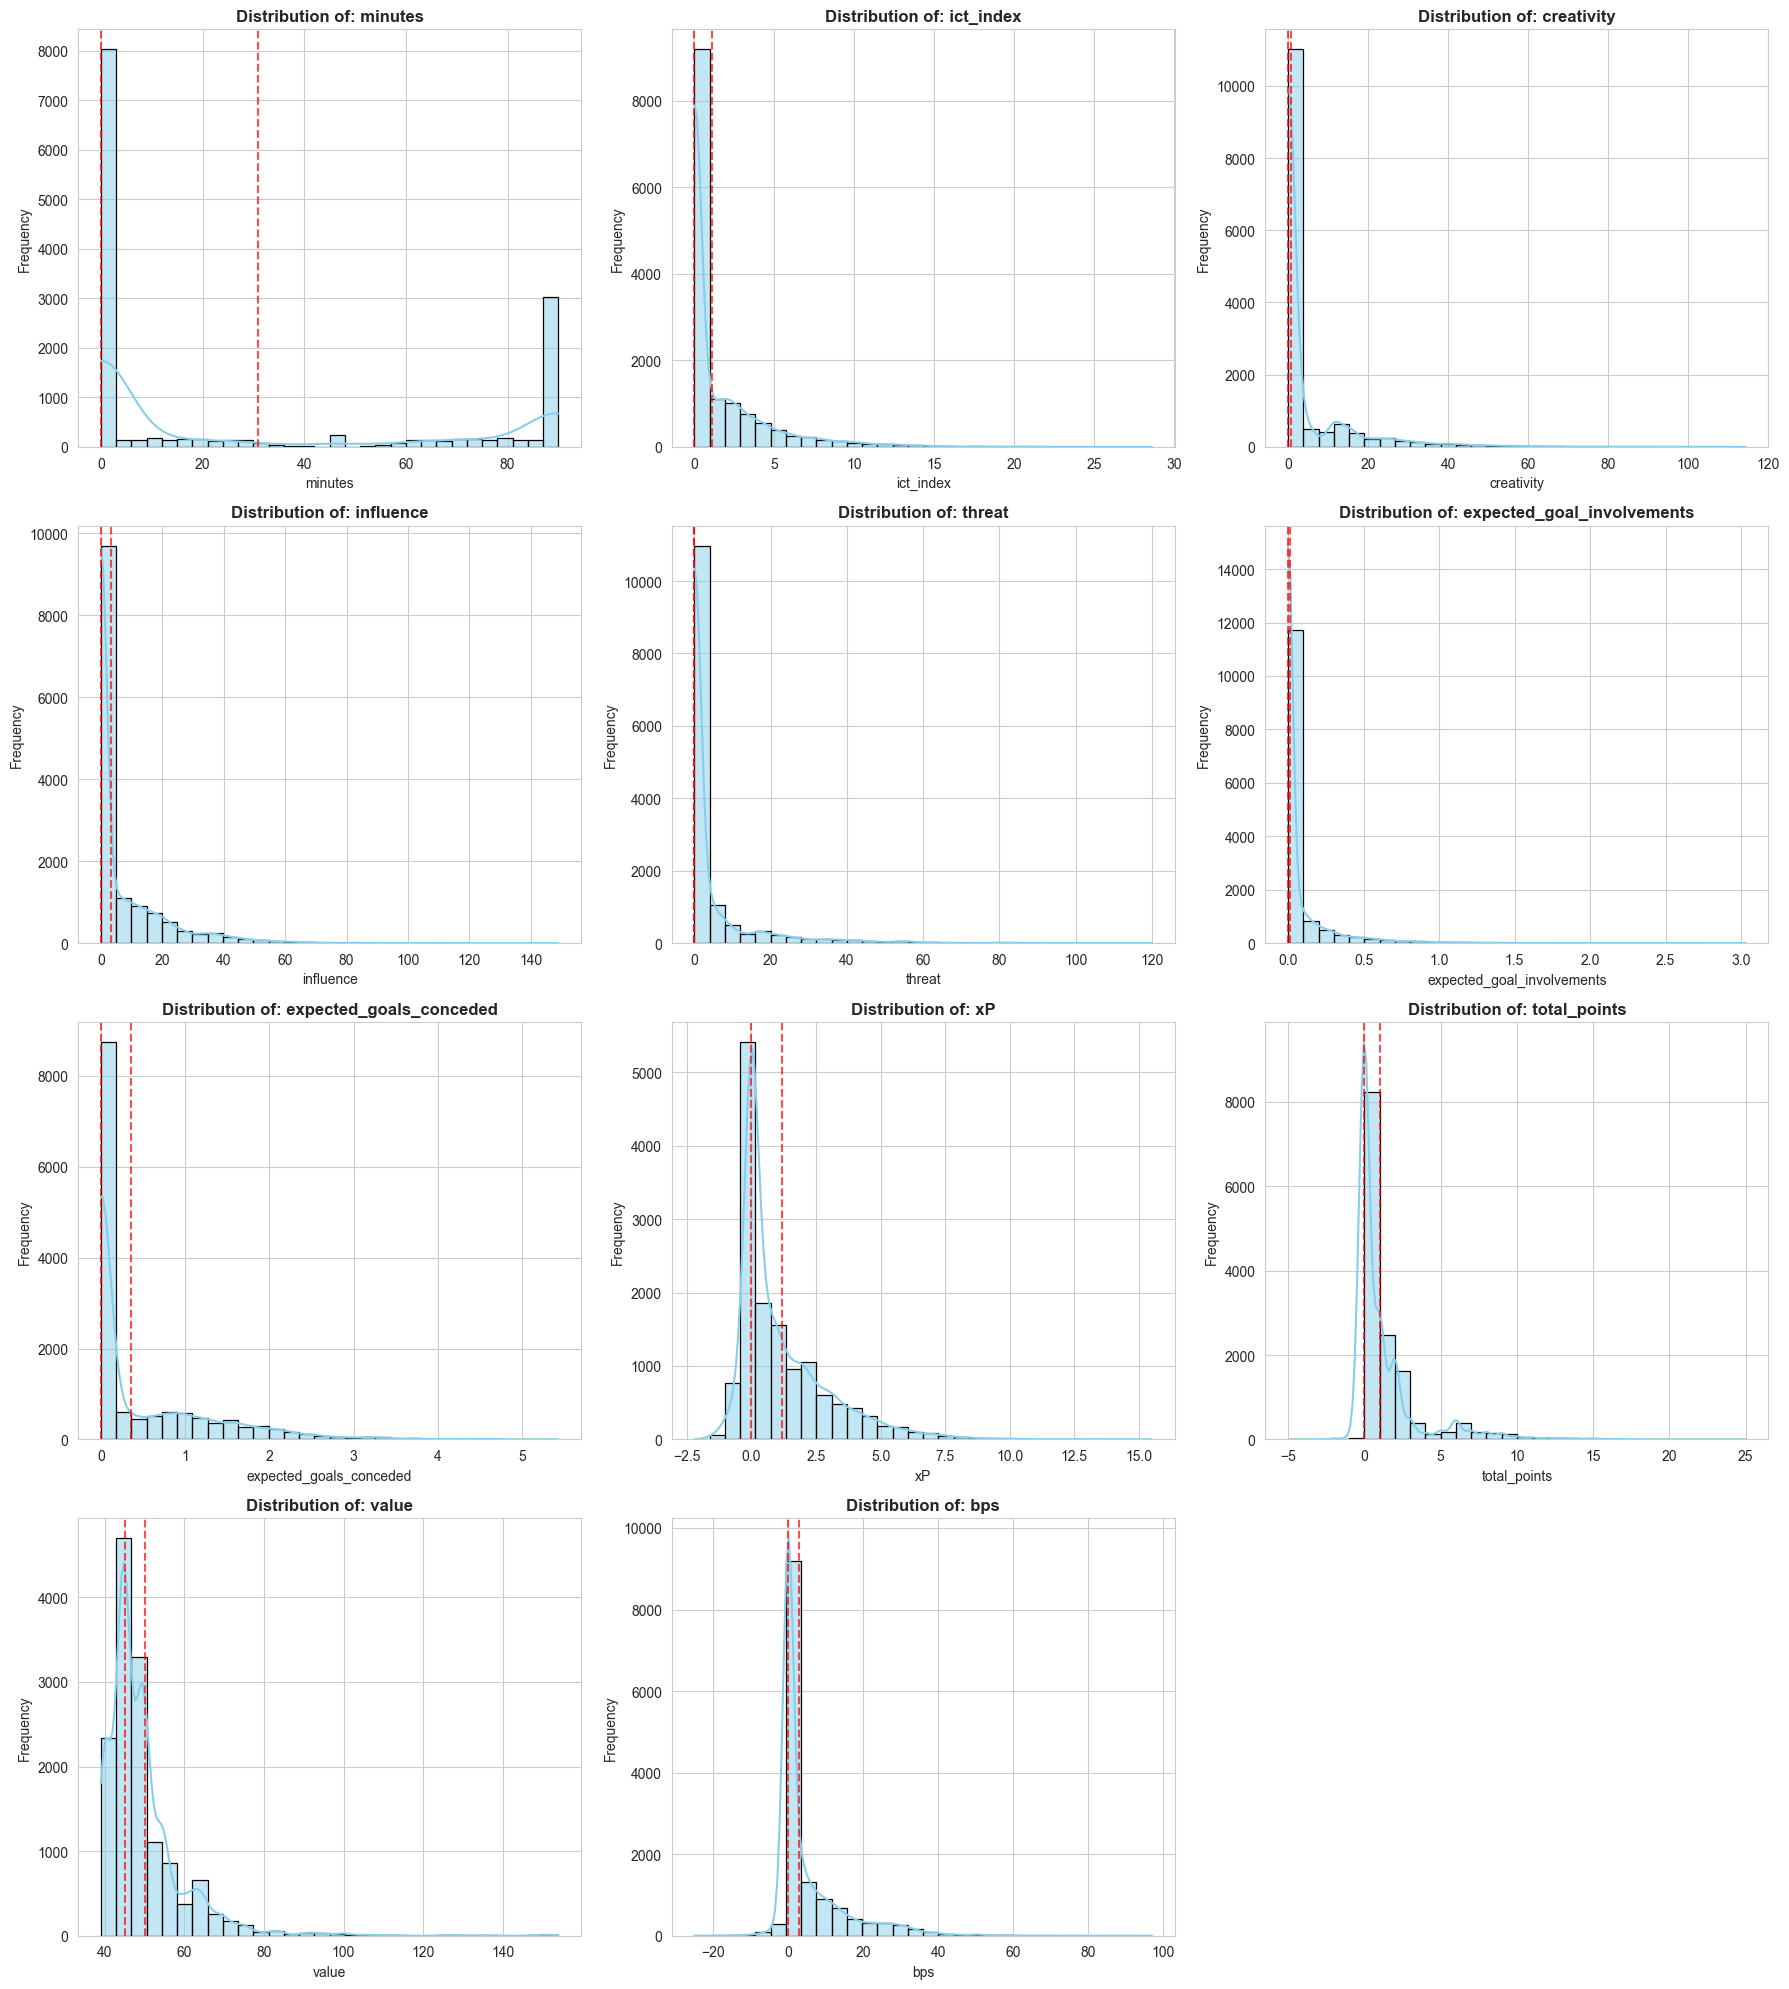

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# List of continuous variables to analyze (including minutes and value)
vars_to_plot = [
    "minutes", 
    "ict_index", "creativity", "influence", "threat",
    "expected_goal_involvements", "expected_goals_conceded",
    "xP", "total_points", "value", "bps"
]

# Plot style configuration
sns.set_style("whitegrid")
n_cols = 3
n_rows = math.ceil(len(vars_to_plot) / n_cols)

plt.figure(figsize=(18, 5 * n_rows))

for i, col in enumerate(vars_to_plot):
    if col in df.columns: # Checks if the column exists in the dataframe
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Histogram with density curve (KDE)
        # 'log_scale' might be useful if there are many small values and few giant ones
        sns.histplot(df[col], kde=True, bins=30, color='skyblue', edgecolor='black')
        
        plt.title(f'Distribution of: {col}', fontsize=12, fontweight='bold')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        
        # Optional: Add vertical lines to simulate where tertiles (33% and 66%) would be
        try:
            quantiles = df[col].quantile([0.33, 0.66]).values
            for q in quantiles:
                plt.axvline(q, color='red', linestyle='--', alpha=0.7, label='Tertile' if q == quantiles[0] else "")
        except:
            pass
    else:
        print(f"Column {col} was not found in the DataFrame.")

plt.tight_layout()
plt.show()

Visual analysis of histograms and density curves (KDE) allowed identifying distinct patterns in variable behavior, requiring specific transformation strategies for each group of attributes. Below, the analytical conclusions and respective implementation code are detailed.

##### **2.1. Participation Treatment (Minutes)**

The ``minutes`` variable presents an extreme bimodal distribution: a sharp peak at 0 (players who did not enter the field) and another around 90 (players who completed the match).

Including players with 0 minutes would generate trivial and analytically worthless association rules (e.g., If did not play $\rightarrow$ Did not score).

**Decision**:

- **Filtering**: Remove all records where minutes == 0.

- **Binarization**: Create the variable ``played_60+``, given that playing more than 60 minutes is a critical threshold in Fantasy Football rules (condition for Clean Sheet and appearance points).

In [10]:
# Remove players who did not enter the field to avoid trivial rules
print(f"Records before filter: {len(df_bin)}")
df_bin = df_bin[df_bin["minutes"] > 0].copy()
print(f"Records after filter (>0 min): {len(df_bin)}")

# Create flag for those who played at least 60 minutes (Business Rule)
df_bin["played_60+"] = (df_bin["minutes"] >= 60).astype(int)

# Remove the original minutes column
df_bin.drop(columns=["minutes"], inplace=True)

Records before filter: 14178
Records after filter (>0 min): 6347


##### **2.2. Discretization of Performance Metrics (ICT, xG, xA)**

Performance variables (such as ``threat``, ``influence``, ``ict_index``, ``expected_goal_involvements``) exhibit strong positive skewness (Right Skew). The majority of players concentrate on low values, while a minority reaches high values. A linear division (equal intervals) would be ineffective.

Therefore, we opted for discretization based on Quantiles (Tertiles), dividing the sample into three groups of equivalent population: Low, Medium, and High. To ensure code robustness against variables with excessive zeros (e.g., 60% of values being 0), a "Safe Discretization" function (``safe_qcut``) was implemented to dynamically adjust intervals.

In [11]:
def safe_qcut(series, k=3, labels=["Low", "Medium", "High"]):
    """
    Helper function: Tries to divide into k quantiles. If there are many repeated values
    (e.g., zeros), it adjusts bins to avoid execution errors.
    """
    try:
        return pd.qcut(series, q=k, labels=labels, duplicates='drop')
    except ValueError:
        return pd.qcut(series, q=k, duplicates='drop').astype(str)

continuous_cols = [
    "ict_index", "creativity", "influence", "threat",
    "expected_goal_involvements", "expected_goals_conceded",
    "xP", "bps"
]

labels_perf = ["Low", "Medium", "High"]

for col in continuous_cols:
    if col in df_bin.columns:
        # 1. Apply safe discretization
        df_bin[col + "_tier"] = safe_qcut(df_bin[col], k=3, labels=labels_perf)
        
        # 2. Add prefix for rule clarity (e.g., 'threat_High')
        df_bin[col + "_tier"] = col + "_" + df_bin[col + "_tier"].astype(str)
        
        # 3. Remove original column
        df_bin.drop(columns=[col], inplace=True)

##### **2.3. Value and Score Segmentation (Context and Target Variables)**

The variables ``value`` (price) and ``total_points`` (final score) present a more uniform distribution or closer to normality compared to game metrics.

**Decision**: We apply division into tertiles with specific semantic labels to facilitate the interpretation of final rules:

- **Value**: Budget, Mid, Premium.

- **Points**: Points_Low, Points_Medium, Points_High.

In [12]:
# --- Target Variable: Total Points ---
if "total_points" in df_bin.columns:
    # Division into performance tertiles
    df_bin["points_tier"] = safe_qcut(df_bin["total_points"], k=3, labels=["Low", "Medium", "High"])
    # Prefix for readability (e.g., Points_High)
    df_bin["points_tier"] = "Points_" + df_bin["points_tier"].astype(str)
    df_bin.drop(columns=["total_points"], inplace=True)

# --- Context Variable: Market Value ---
if "value" in df_bin.columns:
    # Division into price ranges
    df_bin["value_tier"] = safe_qcut(df_bin["value"], k=3, labels=["Budget", "Mid", "Premium"])
    # Prefix (e.g., Value_Premium)
    df_bin["value_tier"] = "Value_" + df_bin["value_tier"].astype(str)
    df_bin.drop(columns=["value"], inplace=True)

# --- Context Variable: Home/Away ---
if "was_home" in df_bin.columns:
    # Ensure binary numeric format (0 or 1)
    df_bin["was_home"] = df_bin["was_home"].astype(int)

# Final result visualization
print("Final transformed columns:")
print(df_bin.columns.tolist())
display(df_bin.head())

Final transformed columns:
['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'starts', 'was_home', 'yellow_cards', 'pos_DEF', 'pos_FWD', 'pos_GK', 'pos_MID', 'team_Arsenal', 'team_Aston Villa', 'team_Bournemouth', 'team_Brentford', 'team_Brighton', 'team_Chelsea', 'team_Crystal Palace', 'team_Everton', 'team_Fulham', 'team_Ipswich', 'team_Leicester', 'team_Liverpool', 'team_Man City', 'team_Man Utd', 'team_Newcastle', "team_Nott'm Forest", 'team_Southampton', 'team_Spurs', 'team_West Ham', 'team_Wolves', 'save_null', 'save_low', 'save_medium', 'save_high', 'played_60+', 'ict_index_tier', 'creativity_tier', 'influence_tier', 'threat_tier', 'expected_goal_involvements_tier', 'expected_goals_conceded_tier', 'xP_tier', 'bps_tier', 'points_tier', 'value_tier']


,assists,bonus,clean_sheets,goals_conceded,goals_scored,own_goals,penalties_missed,penalties_saved,red_cards,starts,was_home,yellow_cards,pos_DEF,pos_FWD,pos_GK,pos_MID,team_Arsenal,team_Aston Villa,team_Bournemouth,team_Brentford,team_Brighton,team_Chelsea,team_Crystal Palace,team_Everton,team_Fulham,team_Ipswich,team_Leicester,team_Liverpool,team_Man City,team_Man Utd,team_Newcastle,team_Nott'm Forest,team_Southampton,team_Spurs,team_West Ham,team_Wolves,save_null,save_low,save_medium,save_high,played_60+,ict_index_tier,creativity_tier,influence_tier,threat_tier,expected_goal_involvements_tier,expected_goals_conceded_tier,xP_tier,bps_tier,points_tier,value_tier
0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,ict_index_Medium,creativity_High,influence_High,"threat_(-0.001, 8.0]",expected_goal_involvements_Low,expected_goals_conceded_Medium,xP_Medium,bps_Medium,Points_Medium,Value_Mid
4,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,ict_index_Medium,creativity_High,influence_Low,"threat_(8.0, 120.0]",expected_goal_involvements_High,expected_goals_conceded_Low,xP_Low,bps_Low,Points_Low,Value_Premium
5,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,ict_index_Medium,creativity_Medium,influence_High,"threat_(-0.001, 8.0]",expected_goal_involvements_Low,expected_goals_conceded_High,xP_Medium,bps_High,Points_Medium,Value_Budget
8,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,ict_index_Medium,creativity_High,influence_Low,"threat_(-0.001, 8.0]",expected_goal_involvements_Medium,expected_goals_conceded_Medium,xP_Low,bps_High,Points_Medium,Value_Premium
12,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,ict_index_Low,creativity_Medium,influence_Medium,"threat_(-0.001, 8.0]",expected_goal_involvements_Medium,expected_goals_conceded_Medium,xP_Low,bps_Medium,Points_Low,Value_Mid


---

## 7. Encoding Discretized Categorical Variables (One-Hot Encoding)

After the discretization process, originally continuous variables were transformed into categories represented by tier intervals.

Typical examples of these categories include:

- `influence_High`
- `threat_(-0.001, 8.0]`
- `creativity_Medium`

These tiers indicate the value range in which the observation falls, allowing future association rule generation to be applied over well-defined categories rather than continuous numerical values.

To make these variables usable in transaction-based models (like Apriori or FP-Growth), it is necessary to encode them in **One-Hot Encoding** format, creating a binary column for each category.

The goal of this step is to:

- explicitly transform each category into binary columns,
- ensure all categorized features are ready for association rule algorithms,
- keep new column names clean and readable, even when dealing with numerical intervals.

Next, One-Hot Encoding is performed for all ``*_tier`` variables.

In [13]:
# 1. Identify columns that need to be encoded
cols_to_encode = [col for col in df_bin.columns if df_bin[col].dtype == 'object' or df_bin[col].dtype.name == 'category']

print(f"Columns to encode: {cols_to_encode}")

# 2. Apply One-Hot Encoding
# prefix='', prefix_sep='' -> Since we already put names in categories (e.g., 'threat_High'),
# we don't want pandas to add more prefixes. The column name will be the value itself.
df_final = pd.get_dummies(df_bin, columns=cols_to_encode, prefix='', prefix_sep='', dtype=int)

# Check if any non-numeric column remains (safety check)
non_numeric = df_final.select_dtypes(exclude=['int', 'int32', 'int64', 'float']).columns
if len(non_numeric) > 0:
    print(f"Warning! Non-numeric columns detected: {non_numeric}")
else:
    print("Success: All columns are numeric.")

# Visualization of the Final Transactional Matrix
print(f"\nFinal Matrix Dimensions: {df_final.shape}")
print("\nExample of first 5 rows (Transactions):")
display(df_final.head())

# List all generated columns to ensure names are correct
print("\nList of Items (Attributes) available for Apriori:")
print(df_final.columns.tolist())

Columns to encode: ['ict_index_tier', 'creativity_tier', 'influence_tier', 'threat_tier', 'expected_goal_involvements_tier', 'expected_goals_conceded_tier', 'xP_tier', 'bps_tier', 'points_tier', 'value_tier']
Success: All columns are numeric.

Final Matrix Dimensions: (6347, 70)

Example of first 5 rows (Transactions):


,assists,bonus,clean_sheets,goals_conceded,goals_scored,own_goals,penalties_missed,penalties_saved,red_cards,starts,was_home,yellow_cards,pos_DEF,pos_FWD,pos_GK,pos_MID,team_Arsenal,team_Aston Villa,team_Bournemouth,team_Brentford,team_Brighton,team_Chelsea,team_Crystal Palace,team_Everton,team_Fulham,team_Ipswich,team_Leicester,team_Liverpool,team_Man City,team_Man Utd,team_Newcastle,team_Nott'm Forest,team_Southampton,team_Spurs,team_West Ham,team_Wolves,save_null,save_low,save_medium,save_high,played_60+,ict_index_High,ict_index_Low,ict_index_Medium,creativity_High,creativity_Low,creativity_Medium,influence_High,influence_Low,influence_Medium,"threat_(-0.001, 8.0]","threat_(8.0, 120.0]",expected_goal_involvements_High,expected_goal_involvements_Low,expected_goal_involvements_Medium,expected_goals_conceded_High,expected_goals_conceded_Low,expected_goals_conceded_Medium,xP_High,xP_Low,xP_Medium,bps_High,bps_Low,bps_Medium,Points_High,Points_Low,Points_Medium,Value_Budget,Value_Mid,Value_Premium
0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0
4,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
5,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0
8,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1
12,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0



List of Items (Attributes) available for Apriori:
['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'starts', 'was_home', 'yellow_cards', 'pos_DEF', 'pos_FWD', 'pos_GK', 'pos_MID', 'team_Arsenal', 'team_Aston Villa', 'team_Bournemouth', 'team_Brentford', 'team_Brighton', 'team_Chelsea', 'team_Crystal Palace', 'team_Everton', 'team_Fulham', 'team_Ipswich', 'team_Leicester', 'team_Liverpool', 'team_Man City', 'team_Man Utd', 'team_Newcastle', "team_Nott'm Forest", 'team_Southampton', 'team_Spurs', 'team_West Ham', 'team_Wolves', 'save_null', 'save_low', 'save_medium', 'save_high', 'played_60+', 'ict_index_High', 'ict_index_Low', 'ict_index_Medium', 'creativity_High', 'creativity_Low', 'creativity_Medium', 'influence_High', 'influence_Low', 'influence_Medium', 'threat_(-0.001, 8.0]', 'threat_(8.0, 120.0]', 'expected_goal_involvements_High', 'expected_goal_involvements_Low', 'expected_goal_involvements_M

---

## 8. Exporting the Processed Dataset

With the conclusion of the preprocessing and transformation phase, the dataset is now converted into a binary transactional matrix, ready to be submitted to data mining algorithms.

To ensure the persistence of this work and allow its use in subsequent steps (or in other notebooks dedicated exclusively to modeling), the final dataframe is exported to a CSV file.

The resulting file, ``merged_gw_processed.csv``, will be stored in the ``data/processed/`` directory and will serve as direct input for the Apriori algorithm.

In [14]:
import os

# Define output path
output_path = "../data/processed/merged_gw_processed.csv"

# Ensure 'data' folder exists (optional, but good practice)
os.makedirs("data", exist_ok=True)

# Export final DataFrame
# index=False is crucial to avoid creating an extra index column upon reloading
df_final.to_csv(output_path, index=False)

print(f"Success: The processed dataset was exported to: {output_path}")
print(f"Dimensions of exported file: {df_final.shape}")

Success: The processed dataset was exported to: ../data/processed/merged_gw_processed.csv
Dimensions of exported file: (6347, 70)


---

## 9. Conclusion

This Exploratory Data Analysis (EDA) fulfilled its primary objective: to transform a raw and heterogeneous Fantasy Premier League dataset into a binary transactional matrix, optimized for the application of association rule mining algorithms (such as Apriori).

Throughout this notebook, critical methodological decisions were implemented to ensure the quality and relevance of the patterns to be extracted subsequently:

1. **Data Curation and Cleaning:** Removing administrative and redundant attributes allowed focusing the analysis strictly on sporting performance. More importantly, filtering out players with zero minutes played eliminated a significant volume of statistical noise, avoiding the generation of trivial rules (e.g., "did not play $\rightarrow$ did not score") that would dilute the quality of results.

2. **Transformation Strategies Adapted to Distribution:** Detailed analysis of histograms and densities (KDE) grounded the application of distinct techniques for different data types:

- **Logical Binarization:** For sparse count events (goals, cards), where the critical distinction is the presence/absence of the event.

- **Quantile Discretization (Tertiles):** For continuous and skewed metrics (ICT Index, BPS, Threat), where segmentation into Low/Medium/High allowed capturing performance nuances that simple binarization would ignore. The introduction of the ``safe_qcut`` function ensured process robustness against zero-inflation.

- **Business Rules:** The creation of specific variables, such as ``played_60+ ``and the segmentation of ``saves``, aligned data treatment with the game's actual scoring rules.

3. **Transactional Matrix Generation:** The final One-Hot Encoding step successfully converted all categorical and discretized variables into binary attributes. The resulting dataframe, ``df_final``, now presents a structure where each row represents a complete game "transaction," described exclusively via presence (1) or absence (0) attributes.

With this, the dataset is now clean, consistent, and mathematically prepared. The generated columns (e.g., ``pos_MID``, ``threat_High``, ``Points_Premium``) constitute a rich vocabulary that will allow the association rule algorithm to discover non-trivial correlations between player position, underlying metrics, and the final return in points.